# Training KN models with tensorflow

## Imports

In [1]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

# NMMA imports
import nmma
from nmma.em.io import read_photometry_files
from nmma.em.utils import interpolate_nans
import inspect 
import nmma.em.model_parameters as model_parameters

MODEL_FUNCTIONS = {
    k: v for k, v in model_parameters.__dict__.items() if inspect.isfunction(v)
}
MODEL_FUNCTIONS
from nmma.em.training import SVDTrainingModel

# Tensorflow imports 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16
        }

plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Install wrapt_timeout_decorator if you want timeout simulations.


2023-12-12 21:44:58.359839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 21:44:58.481647: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-12 21:44:59.021196: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: ~/MultiNest/lib/
2023-12-12 21:44:59.021276: W tensorflow/compiler/xla/stream_executor/

## Preliminaries

In [3]:
# Choose model and set location of the kilonova lightcurves
bulla_2022_dir = "/home/urash/twouters/KN_Lightcurves/lightcurves/lcs_bulla_2022"
bulla_2019_dir = "/home/urash/twouters/KN_Lightcurves/lightcurves/lcs_bulla_2019"

# Choose the model here
# model_name = "Bu2022Ye"
model_name = "Bu2019lm"
model_function = MODEL_FUNCTIONS[model_name]

# Set the location of the lightcurves and outdir based on chosen model
if model_name == "Bu2022Ye":
    lcs_dir = bulla_2022_dir
    
elif model_name == "Bu2019lm":
    lcs_dir = bulla_2019_dir

outdir = f"/home/urash/twouters/new_nmma_models/"

# Process the KN lightcurves
filenames = os.listdir(lcs_dir)
full_filenames = [os.path.join(lcs_dir, f) for f in filenames]
print(f"There are {len(full_filenames)} lightcurves for this model.")

print("Reading lightcurves and interpolating NaNs...")
data = read_photometry_files(full_filenames)
data = interpolate_nans(data)
keys = list(data.keys())
filts = sorted(list(set(data[keys[0]].keys()) - {"t"}))

print("Original filters:")
print(filts)

print("Reading lightcurves and interpolating NaNs... DONE")

# Limit to the filters of interest for the KN event that Peter is interested in:
if model_name == "Bu2022Ye":
    filts = ["ztfg", "ztfi", "ztfr"] # limited for now for Peter's KN event
else:
    filts = [f for f in filts if "sdss" in f]

print("Filters:")
print(filts)

# Get the time array
dat = pd.read_csv(full_filenames[0], delimiter=" ", escapechar='#')
dat = dat.rename(columns={" t[days]": "t"})
t = dat["t"].values

print("Genrating training data...")
training_data, parameters = model_function(data)
print("Genrating training data... DONE")

print("Getting SVD model")
svd_ncoeff = 10
training_model = SVDTrainingModel(
        model_name,
        training_data,
        parameters,
        t,
        filts,
        n_coeff=svd_ncoeff,
        interpolation_type="tensorflow",
        svd_path=outdir,
        start_training=False, # don't train, just prep the data
        load_model=False, # don't load a model, just prep the data
    )
print("Getting SVD model DONE")

print("Generating SVD model")
svd_model = training_model.generate_svd_model()
training_model.svd_model = svd_model
print("Generating SVD model DONE")

There are 1596 lightcurves for this model.
Reading lightcurves and interpolating NaNs...
Original filters:
['bessellb', 'besselli', 'bessellr', 'bessellux', 'bessellv', 'cspk', 'sdss__g', 'sdss__i', 'sdss__r', 'sdss__u', 'sdss__z', 'swope2__H', 'swope2__J', 'swope2__y', 'uvot__b', 'uvot__u', 'uvot__uvm2', 'uvot__uvw1', 'uvot__uvw2', 'uvot__v', 'uvot__white']
Reading lightcurves and interpolating NaNs... DONE
Filters:
['sdss__g', 'sdss__i', 'sdss__r', 'sdss__u', 'sdss__z']
Genrating training data...
Genrating training data... DONE
Getting SVD model
The grid will be interpolated to sample_time with interp1d
Not loading new model
Getting SVD model DONE
Generating SVD model
Normalizing mag filter sdss__g...
Normalizing mag filter sdss__i...
Normalizing mag filter sdss__r...
Normalizing mag filter sdss__u...
Normalizing mag filter sdss__z...
Generating SVD model DONE


In [8]:
# sanity check
parameters

['log10_mej_dyn', 'log10_mej_wind', 'KNphi', 'KNtheta']

## Training TF model

In [4]:
training_history_list = []

for i, f in enumerate(filts):
    
    print(f"============================================================================================================")
    print(f"Training {f} filter ({i+1}/{len(filts)})")

    X = training_model.svd_model[f]['param_array_postprocess'] # complete dataset of input data of network
    n_samples, input_ndim = X.shape
    print(f"Features (input) have shape {X.shape}")

    y = training_model.svd_model[f]['cAmat'].T
    _, output_ndim = y.shape
    print(f"Labels (output) have shape {y.shape}")
    
    # Perform train-validation split
    train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=0)
    
    model = Sequential()
    model.add(
        Dense(
            128,
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=(train_X.shape[1],),
        )
    )
    model.add(
        Dense(
            256,
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=(train_X.shape[1],),
        )
    )
    model.add(
        Dense(
            256,
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=(train_X.shape[1],),
        )
    )
    model.add(
        Dense(
            128,
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=(train_X.shape[1],),
        )
    )
    model.add(Dense(training_model.n_coeff))

    # # Show the architecture:
    # model.summary()
    
    model.compile(optimizer="adam", loss="mse")
    n_epochs = 100

    # fit the model
    training_history = model.fit(
        train_X,
        train_y,
        epochs=n_epochs,
        batch_size=32,
        validation_data=(val_X, val_y),
        verbose=True,
    )
    
    training_model.svd_model[f]["model"] = model
    training_history_list.append(training_history)

Training sdss__g filter (1/5)
Features (input) have shape (1596, 4)
Labels (output) have shape (1596, 10)
Epoch 1/100


2023-12-12 21:47:20.404962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 21:47:20.974525: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21952 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:73:00.0, compute capability: 7.5
2023-12-12 21:47:22.314240: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x34767de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-12 21:47:22.314310: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2023-12-12 21:47:22.329402: I tensorflow/compil

45/45 [==============================] - 2s 9ms/step - loss: 0.5875 - val_loss: 0.1309
Epoch 2/100
45/45 [==============================] - 0s 7ms/step - loss: 0.0958 - val_loss: 0.0854
Epoch 3/100
45/45 [==============================] - 0s 7ms/step - loss: 0.0775 - val_loss: 0.0715
Epoch 4/100
45/45 [==============================] - 0s 7ms/step - loss: 0.0675 - val_loss: 0.0627
Epoch 5/100
45/45 [==============================] - 0s 7ms/step - loss: 0.0601 - val_loss: 0.0560
Epoch 6/100
45/45 [==============================] - 0s 7ms/step - loss: 0.0517 - val_loss: 0.0494
Epoch 7/100
45/45 [==============================] - 0s 7ms/step - loss: 0.0437 - val_loss: 0.0380
Epoch 8/100
45/45 [==============================] - 0s 7ms/step - loss: 0.0345 - val_loss: 0.0302
Epoch 9/100
45/45 [==============================] - 0s 7ms/step - loss: 0.0274 - val_loss: 0.0224
Epoch 10/100
45/45 [==============================] - 0s 7ms/step - loss: 0.0209 - val_loss: 0.0181
Epoch 11/100
45/45 [=

### Training history to check for overfitting

Final training loss sdss__g: 0.0034904261119663715
Final validation loss sdss__g: 0.004227380268275738


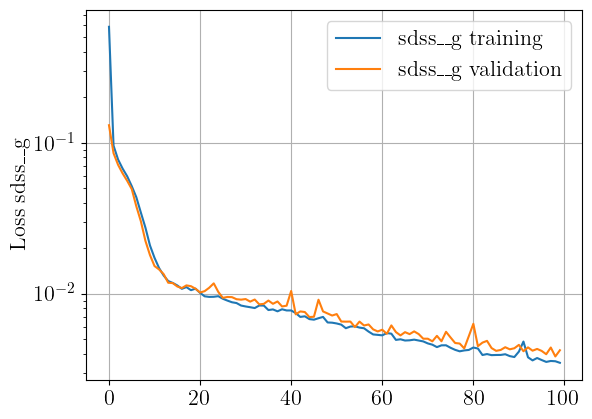

Final training loss sdss__i: 0.004739328287541866
Final validation loss sdss__i: 0.005824120715260506


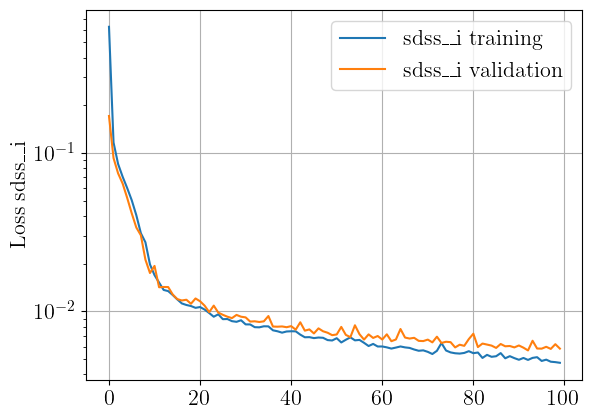

Final training loss sdss__r: 0.0050185732543468475
Final validation loss sdss__r: 0.006108277477324009


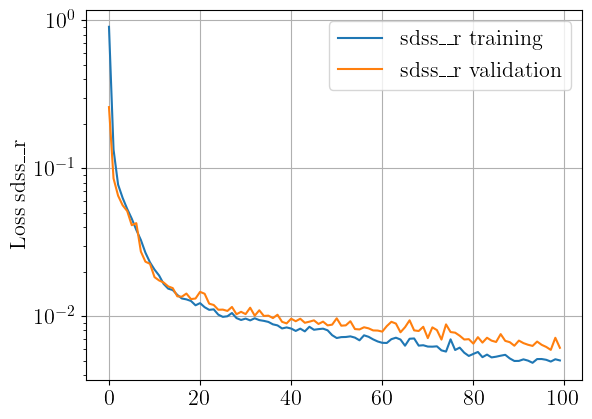

Final training loss sdss__u: 0.003140693297609687
Final validation loss sdss__u: 0.003452293574810028


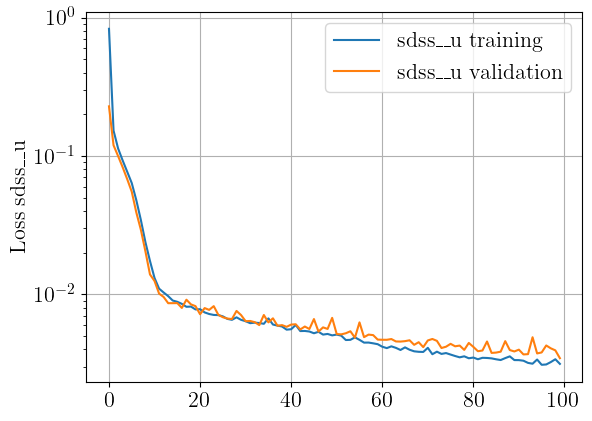

Final training loss sdss__z: 0.002075013006106019
Final validation loss sdss__z: 0.0027852230705320835


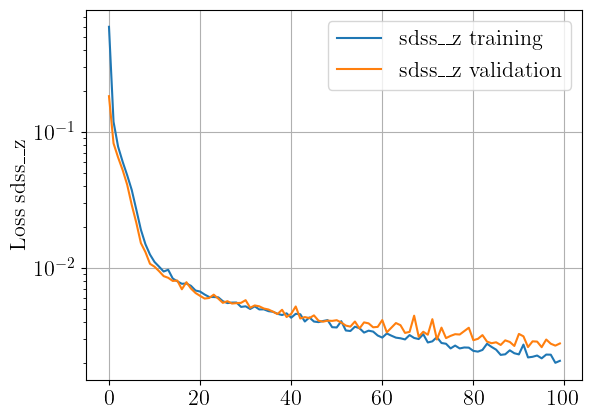

In [9]:
for filt, history in zip(filts, training_history_list):
    # Print the final loss values for training and validation
    print(f"Final training loss {filt}: {history.history['loss'][-1]}")
    print(f"Final validation loss {filt}: {history.history['val_loss'][-1]}")
        
    # Plot training & validation loss values
    plt.plot(history.history['loss'], label=f"{filt} training")
    plt.plot(history.history['val_loss'], label=f"{filt} validation")
    plt.yscale("log")
    plt.ylabel(f"Loss {filt}")
    plt.legend()
    plt.show()
    plt.close()

## Save the model

In [6]:
# training_model.save_model()

## Check output on a lightcurve (as sanity check for comparison notebook)

We will load the model for simplicity

In [7]:
from nmma.em.model import SVDLightCurveModel

lc_model = SVDLightCurveModel(
        model_name,
        t,
        svd_path=outdir,
        parameter_conversion=None,
        mag_ncoeff=10,
        lbol_ncoeff=None,
        interpolation_type="tensorflow",
        model_parameters=None,
        filters=filts,
        local_only=True
)

Loaded filter sdss__g
Loaded filter sdss__i
Loaded filter sdss__r
Loaded filter sdss__u
Loaded filter sdss__z


Load the model again (some bug in the code)

In [ ]:
# Get the normalized parameters of the first lightcurve of our dataset
idx = 0

print("Example parameters for input in surrogate model:")
key = list(training_data.keys())[idx]
example_parameters = [training_data[key][param] for param in parameters]
example_parameters = np.array(example_parameters)
print(example_parameters)

# Get the magnitude of this filter
_, _, mAB = nmma.em.utils.calc_lc(t,
                                example_parameters, 
                                svd_mag_model = lc_model.svd_mag_model, 
                                interpolation_type="tensorflow", 
                                filters = filts, 
                                mag_ncoeff = 10
                                )

Example parameters for input in surrogate model:
[-2.30103  0.12     0.3     -1.30103  0.03    25.84   ]


In [ ]:
mAB

{'ztfg': array([-15.40716493, -17.85132963, -17.93466051, -17.94338929,
        -17.954362  , -17.90531135, -17.87865032, -17.81997628,
        -17.71883239, -17.61664214, -17.49636329, -17.40415758,
        -17.30430941, -17.21205518, -17.12051219, -17.03351561,
        -16.95730989, -16.87534337, -16.81940932, -16.75728175,
        -16.70452207, -16.65655036, -16.59519414, -16.54192163,
        -16.49767474, -16.44302867, -16.40013333, -16.35874872,
        -16.32983869, -16.30479631, -16.28703132, -16.28295964,
        -16.28202869, -16.31978963, -16.35385262, -16.34791529,
        -16.3329581 , -16.30118915, -16.25199978, -16.20215121,
        -16.14519413, -16.08555617, -16.01909835, -15.96103787,
        -15.89506334, -15.8659964 , -15.85119122, -15.80262963,
        -15.76142388, -15.68569311, -15.5903519 , -15.49569909,
        -15.37531779, -15.25225077, -15.12342888, -14.98840377,
        -14.85784501, -14.6886528 , -14.48940981, -14.29010252,
        -14.08085054, -13.871141